In [25]:
import numpy as np
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
from shapely.geometry import Polygon, Point
from shapely.vectorized import contains  # use contains_xy se estiver com Shapely >= 2.0

def define_geo_points(polygon,num_required):
    minx, miny, maxx, maxy = polygon.bounds
    area_bbox = (maxx - minx) * (maxy - miny)
    area_polygon = polygon.area

    # Gerar pontos vetorialmente
    batch_size = int(num_required /(area_polygon/area_bbox))  # margem para garantir cobertura
    a = 2.326  # z para 99%
    batch_size = int((num_required + a /2 + a*(num_required + a/4)**0.5)/(area_polygon/area_bbox))  # margem para garantir cobertura
    x = np.random.uniform(minx, maxx, batch_size)
    y = np.random.uniform(miny, maxy, batch_size)
    
    # Filtrar vetorialmente os pontos dentro do polígono
    mask = contains(polygon, x, y)  # use contains_xy se estiver com Shapely >= 2.0
    valid_coords = np.column_stack((x[mask], y[mask]))

    # Selecionar os primeiros 55.000 pontos válidos
    selected_coords = valid_coords[:int(num_required)]
    
    if len(valid_coords) < num_required:
        print(batch_size, len(valid_coords))
        selected_coords = define_geo_points(polygon,num_required)
    
    return selected_coords

In [26]:
import pandas as pd
import zipfile
import geopandas as gpd

def open_shapefile(estado, path='', zip=False):
    # if zip:
    #     # shp = f"C:/Users/carlo/Downloads/{estado}_setores_CD2022/{estado}_setores_CD2022.shp"
    #     shp = f"source/{estado}_setores_CD2022/{estado}_setores_CD2022.shp"
    #     gdf = gpd.read_file(shp)
    #     return gdf
    # Caminho para o arquivo ZIP
    zip_path = f"source/{estado}_setores_CD2022.zip"

    # Nome do shapefile dentro do ZIP (sem o caminho completo)
    shapefile_name = f"{estado}_setores_CD2022.shp"

    # Caminho completo usando o protocolo zip
    zip_shapefile_path = f"zip://{zip_path}!{shapefile_name}"

    # Lê diretamente o shapefile do ZIP
    gdf = gpd.read_file(zip_shapefile_path)
    return gdf

def open_csv(path, zip = False):
    # if zip:
    #     # csv = "C:/Users/carlo/Downloads/Agregados_por_setores_demografia_BR/Agregados_por_setores_demografia_BR.csv"
    #     csv = 'source/Agregados_por_setores_demografia_BR/Agregados_por_setores_demografia_BR.csv'
    #     df = pd.read_csv(csv, sep = ';')

    #     return df
    # Caminho para o arquivo ZIP
    zip_path = "source/Agregados_por_setores_demografia_BR.zip"

    # Nome do CSV dentro do ZIP
    csv_filename = 'Agregados_por_setores_demografia_BR.csv'

    # Abre o ZIP e lê o CSV diretamente
    with zipfile.ZipFile(zip_path) as z:
        with z.open(csv_filename) as f:
            df = pd.read_csv(f, sep=';')
    
    return df

def open_csv_dom(path, zip = False):
    # if zip:
    #     # csv = "C:/Users/carlo/Downloads/Agregados/Agregados_por_setores_caracteristicas_domicilio1_BR.csv"
    #     csv = "source/Agregados/Agregados_por_setores_caracteristicas_domicilio1_BR.csv"
    #     df = pd.read_csv(csv, sep = ';')

    #     return df
    # Caminho para o arquivo ZIP
    zip_path = "source/Agregados_por_setores_caracteristicas_domicilio1_BR.zip"

    # Nome do CSV dentro do ZIP
    csv_filename = 'Agregados_por_setores_caracteristicas_domicilio1_BR.csv'

    # Abre o ZIP e lê o CSV diretamente
    with zipfile.ZipFile(zip_path) as z:
        with z.open(csv_filename) as f:
            df = pd.read_csv(f, sep=';')
    
    return df


In [27]:
# Definir o polígono (exemplo)
polygon_coords = [(0, 0), (5, 1), (6, 4), (3, 6), (1, 5), (0, 3)]
polygon = Polygon(polygon_coords)

### Testar se o valor de ponntos extra é um bom valor
for a in range(1000):
    define_geo_points(polygon,1000)

In [28]:
STATE_NAME = "AP"
CITY_NAME = "Oiapoque"

gdf = open_shapefile(STATE_NAME, zip = True)

df_dom = open_csv_dom("", zip = True)
df_dom['CD_setor'] = df_dom['CD_setor'].astype('str')
cols =['V00001', 'V00002', 'V00003']
df_dom[cols] = df_dom[cols].apply(pd.to_numeric, errors='coerce')
df_dom['num_domicilios'] = df_dom[cols].sum(axis=1)

# Lista de grupos de colunas para cada número de moradores
grupos_moradores = {
    'moradores1': ['V00017', 'V00027', 'V00037'],
    'moradores2': ['V00018', 'V00028', 'V00038'],
    'moradores3': ['V00019', 'V00029', 'V00039'],
    'moradores4': ['V00020', 'V00030', 'V00040'],
    'moradores5': ['V00021', 'V00031', 'V00041'],
    'moradores6': ['V00022', 'V00032', 'V00042'],
    'moradores7': ['V00023', 'V00033', 'V00043'],
    'moradores8': ['V00024', 'V00034', 'V00044'],
    'moradores9': ['V00025', 'V00035', 'V00045'],
    'moradores10': ['V00026', 'V00036', 'V00046']
}

# Aplicar para cada grupo
for nome_coluna, colunas in grupos_moradores.items():
    df_dom[colunas] = df_dom[colunas].apply(pd.to_numeric, errors='coerce')
    df_dom[nome_coluna] = df_dom[colunas].sum(axis=1)


cols = ['moradores1', 'moradores2', 'moradores3', 'moradores4', 'moradores5', 
              'moradores6', 'moradores7', 'moradores8', 'moradores9', 'moradores10']
df_dom[cols] = df_dom[cols].apply(pd.to_numeric, errors='coerce')
df_dom['num_domicilios_moradores'] = df_dom[cols].sum(axis=1)

# Mostrar as novas colunas criadas
df_dom = df_dom[['CD_setor','num_domicilios', 'num_domicilios_moradores']+cols]
df_dom.head()

C:\Users\carlo\AppData\Local\Temp\ipykernel_22264\273867693.py:60: DtypeWarning: Columns (1,3,4,5,7,8,9,10,11,13,14,15,16,17,20,21,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,51,52,53,54,56,57,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,77,78,84,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=';')


,CD_setor,num_domicilios,num_domicilios_moradores,moradores1,moradores2,moradores3,moradores4,moradores5,moradores6,moradores7,moradores8,moradores9,moradores10
0,110001505000002,336.0,334.0,52.0,113.0,78.0,62.0,21.0,8.0,0.0,0.0,0.0,0.0
1,110001505000003,208.0,206.0,39.0,67.0,50.0,37.0,10.0,3.0,0.0,0.0,0.0,0.0
2,110001505000004,85.0,84.0,16.0,31.0,18.0,11.0,8.0,0.0,0.0,0.0,0.0,0.0
3,110001505000006,281.0,279.0,55.0,87.0,68.0,36.0,18.0,8.0,7.0,0.0,0.0,0.0
4,110001505000007,291.0,288.0,58.0,93.0,73.0,54.0,10.0,0.0,0.0,0.0,0.0,0.0


In [29]:
df_dom[df_dom.num_domicilios != df_dom.num_domicilios_moradores]

,CD_setor,num_domicilios,num_domicilios_moradores,moradores1,moradores2,moradores3,moradores4,moradores5,moradores6,moradores7,moradores8,moradores9,moradores10
0,110001505000002,336.0,334.0,52.0,113.0,78.0,62.0,21.0,8.0,0.0,0.0,0.0,0.0
1,110001505000003,208.0,206.0,39.0,67.0,50.0,37.0,10.0,3.0,0.0,0.0,0.0,0.0
2,110001505000004,85.0,84.0,16.0,31.0,18.0,11.0,8.0,0.0,0.0,0.0,0.0,0.0
3,110001505000006,281.0,279.0,55.0,87.0,68.0,36.0,18.0,8.0,7.0,0.0,0.0,0.0
4,110001505000007,291.0,288.0,58.0,93.0,73.0,54.0,10.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
458765,530010805440137,52.0,50.0,10.0,12.0,16.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0
458767,530010805440139,10.0,9.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0
458769,530010805440141,145.0,140.0,33.0,41.0,33.0,26.0,7.0,0.0,0.0,0.0,0.0,0.0
458770,530010805440142,107.0,105.0,12.0,25.0,24.0,28.0,10.0,6.0,0.0,0.0,0.0,0.0


In [30]:
df = open_csv("", zip = True)
df['CD_setor'] = df['CD_setor'].astype('str')
df.head()

C:\Users\carlo\AppData\Local\Temp\ipykernel_22264\273867693.py:40: DtypeWarning: Columns (1,2,3,4,9,18,25,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=';')


,CD_setor,V01006,V01007,V01008,V01009,V01010,V01011,V01012,V01013,V01014,...,V01032,V01033,V01034,V01035,V01036,V01037,V01038,V01039,V01040,V01041
0,110001505000002,928,428,500,30,39,24,44,36,25,...,68,62,88,68,58,144,129,124,66,53
1,110001505000003,556,270,286,15,20,20,19,30,20,...,36,47,38,47,44,83,95,48,47,34
2,110001505000004,222,108,114,5,4,9,14,7,5,...,11,15,26,11,11,33,37,25,23,17
3,110001505000006,785,408,377,36,33,34,41,42,27,...,63,61,75,71,53,124,92,88,57,40
4,110001505000007,748,373,375,28,25,33,27,24,31,...,52,54,52,51,61,110,116,93,63,46


In [31]:
df = df[['CD_setor', 'V01006', 'V01009', 'V01010', 'V01011', 'V01012', 'V01013', 'V01014', 'V01015', 
   'V01016', 'V01017', 'V01018', 'V01019', 'V01020', 'V01021', 'V01022', 'V01023', 'V01024', 'V01025', 
   'V01026', 'V01027', 'V01028', 'V01029','V01030']]

df

,CD_setor,V01006,V01009,V01010,V01011,V01012,V01013,V01014,V01015,V01016,...,V01021,V01022,V01023,V01024,V01025,V01026,V01027,V01028,V01029,V01030
0,110001505000002,928,30,39,24,44,36,25,63,53,...,29,38,44,32,33,81,76,67,32,30
1,110001505000003,556,15,20,20,19,30,20,46,45,...,16,27,19,17,24,37,50,27,27,20
2,110001505000004,222,5,4,9,14,7,5,16,13,...,7,6,12,4,6,17,24,11,13,6
3,110001505000006,785,36,33,34,41,42,27,65,42,...,30,27,34,29,26,59,50,50,25,22
4,110001505000007,748,28,25,33,27,24,31,52,52,...,27,21,25,27,30,58,64,43,34,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458767,530010805440139,36,3,X,X,0,0,3,3,X,...,X,X,3,X,X,4,3,X,X,0
458768,530010805440140,633,18,18,31,18,27,29,36,43,...,23,20,20,39,30,53,53,32,33,20
458769,530010805440141,387,12,14,12,17,10,19,27,29,...,13,14,7,12,18,36,28,33,13,19
458770,530010805440142,348,9,12,13,20,17,11,24,28,...,7,20,24,14,10,31,38,21,9,0


In [32]:
gdf = gdf[gdf['NM_MUN']==CITY_NAME][['CD_SETOR','SITUACAO','NM_DIST','NM_SUBDIST','NM_BAIRRO','NM_MUN', 'geometry']].reset_index(drop=True)
gdf

,CD_SETOR,SITUACAO,NM_DIST,NM_SUBDIST,NM_BAIRRO,NM_MUN,geometry
0,160050105000001,Urbana,Oiapoque,None,None,Oiapoque,"POLYGON ((-51.83259 3.84679, -51.83315 3.84813..."
1,160050105000004,Urbana,Oiapoque,None,None,Oiapoque,"POLYGON ((-51.83491 3.84363, -51.83539 3.84338..."
2,160050105000007,Rural,Oiapoque,None,None,Oiapoque,"POLYGON ((-51.76159 3.97477, -51.76783 3.96367..."
3,160050105000008,Rural,Oiapoque,None,None,Oiapoque,"POLYGON ((-51.69066 3.96071, -51.69301 3.95662..."
4,160050105000009,Rural,Oiapoque,None,None,Oiapoque,"POLYGON ((-51.63154 4.0493, -51.63175 4.04934,..."
...,...,...,...,...,...,...,...
92,160050115000029,Rural,Vila Velha,None,None,Oiapoque,"POLYGON ((-51.34329 3.30718, -51.34315 3.30778..."
93,160050115000030,Rural,Vila Velha,None,None,Oiapoque,"POLYGON ((-51.53538 3.33891, -51.52628 3.34307..."
94,160050120000001,Rural,Vila Brasil,None,None,Oiapoque,"POLYGON ((-52.3231 3.17078, -52.32306 3.15922,..."
95,160050120000002,Rural,Vila Brasil,None,None,Oiapoque,"POLYGON ((-52.23693 3.23941, -52.23329 3.23565..."


<Axes: >

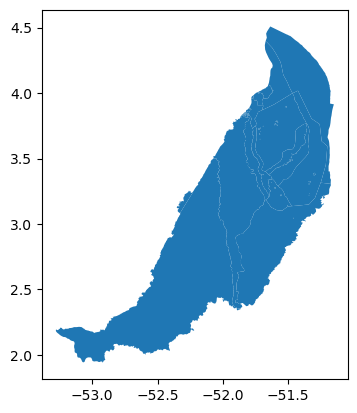

In [33]:
gdf.plot()

In [34]:
setores = gdf.merge(df, left_on='CD_SETOR', right_on='CD_setor', how='left')
setores = setores.merge(df_dom, left_on='CD_SETOR', right_on='CD_setor', how='left')

lista = ['V01006', 'V01009', 'V01010', 'V01011', 'V01012', 'V01013', 'V01014', 'V01015', 
   'V01016', 'V01017', 'V01018', 'V01019', 'V01020', 'V01021', 'V01022', 'V01023', 'V01024', 'V01025', 
   'V01026', 'V01027', 'V01028', 'V01029','V01030']

setores = setores.replace('X',np.nan)
setores = setores.fillna(0)
setores[lista] = setores[lista].astype('int16') 
setores = setores[setores['V01006']>0].reset_index(drop=True)
setores['soma'] = setores[lista[1:]].sum(axis=1) 
#### Existe diferença entre o total e a soma pelos recortes de idade e sexo. ### Pelo menos no Rio de Janeiro.
setores

C:\Users\carlo\AppData\Local\Temp\ipykernel_22264\515789728.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  setores = setores.fillna(0)


,CD_SETOR,SITUACAO,NM_DIST,NM_SUBDIST,NM_BAIRRO,NM_MUN,geometry,CD_setor_x,V01006,V01009,...,moradores2,moradores3,moradores4,moradores5,moradores6,moradores7,moradores8,moradores9,moradores10,soma
0,160050105000001,Urbana,Oiapoque,0,0,Oiapoque,"POLYGON ((-51.83259 3.84679, -51.83315 3.84813...",160050105000001,702,32,...,41.0,42.0,37.0,25.0,11.0,4.0,5.0,5.0,0.0,702
1,160050105000004,Urbana,Oiapoque,0,0,Oiapoque,"POLYGON ((-51.83491 3.84363, -51.83539 3.84338...",160050105000004,812,34,...,51.0,47.0,48.0,32.0,14.0,5.0,0.0,0.0,0.0,812
2,160050105000007,Rural,Oiapoque,0,0,Oiapoque,"POLYGON ((-51.76159 3.97477, -51.76783 3.96367...",160050105000007,25,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,160050105000008,Rural,Oiapoque,0,0,Oiapoque,"POLYGON ((-51.69066 3.96071, -51.69301 3.95662...",160050105000008,18,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
4,160050105000011,Rural,Oiapoque,0,0,Oiapoque,"POLYGON ((-51.7826 3.57195, -51.78257 3.57295,...",160050105000011,42,0,...,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,160050115000027,Rural,Vila Velha,0,0,Oiapoque,"POLYGON ((-51.32989 3.32634, -51.32612 3.32124...",160050115000027,21,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
76,160050115000029,Rural,Vila Velha,0,0,Oiapoque,"POLYGON ((-51.34329 3.30718, -51.34315 3.30778...",160050115000029,23,3,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,6
77,160050120000001,Rural,Vila Brasil,0,0,Oiapoque,"POLYGON ((-52.3231 3.17078, -52.32306 3.15922,...",160050120000001,240,7,...,24.0,18.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,239
78,160050120000002,Rural,Vila Brasil,0,0,Oiapoque,"POLYGON ((-52.23693 3.23941, -52.23329 3.23565...",160050120000002,29,4,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20


In [35]:
pops = setores[cols[0]]*0
for a in range(len(cols)):
    pops += setores[cols[a]] * (a+1)
setores['pops'] = pops

In [36]:
sum(setores['pops']),sum(setores['V01006']),sum(setores['soma'])

(24749.0, 27312, 26733)

In [37]:
setores[setores['pops']> setores['soma']][['CD_SETOR','V01006','soma', 'pops']]

,CD_SETOR,V01006,soma,pops
4,160050105000011,42,19,24.0
26,160050105000044,38,13,21.0
38,160050105000078,31,16,18.0
71,160050115000017,28,17,28.0
76,160050115000029,23,6,15.0


In [38]:
lista_points = []
dict_points = {}
for a in tqdm(setores[['CD_SETOR', 'geometry','num_domicilios_moradores']].itertuples()):
    p = define_geo_points(a.geometry,int(a.num_domicilios_moradores))
    lista_points.append({'cd_setor': a.CD_SETOR,'points':p})
    dict_points[a.CD_SETOR] = p

# Transformar cada array de coordenadas em um GeoDataFrame de pontos
# gdf_points = gpd.GeoDataFrame(
#     geometry=[Point(xy) for arr in lista_points for xy in arr],
#     crs="EPSG:4326"
# )
# gdf_points

80it [00:00, 2390.46it/s]

262 117


In [39]:
lista_points[0]

{'cd_setor': '160050105000001',
 'points': array([[-51.82827085,   3.84975652],
        [-51.83209472,   3.84869853],
        [-51.83147047,   3.84770451],
        [-51.83143812,   3.84901004],
        [-51.82925874,   3.85031861],
        [-51.83262427,   3.84764364],
        [-51.82802052,   3.84958425],
        [-51.82856097,   3.84933539],
        [-51.8325268 ,   3.84697892],
        [-51.82922925,   3.84980452],
        [-51.83049923,   3.84854412],
        [-51.82897819,   3.84915776],
        [-51.82932882,   3.84872484],
        [-51.83273368,   3.84785268],
        [-51.82862886,   3.85011348],
        [-51.83097038,   3.84895071],
        [-51.82955269,   3.84862993],
        [-51.83165247,   3.84810517],
        [-51.83157038,   3.84772083],
        [-51.83186246,   3.84824356],
        [-51.83006004,   3.84886427],
        [-51.8306995 ,   3.84943096],
        [-51.82848829,   3.84941819],
        [-51.82919753,   3.84944189],
        [-51.83017444,   3.84963296],
        

In [40]:
t = {'V01009': 'Sexo masculino, 0 a 4 anos',
 'V01010': 'Sexo masculino, 5 a 9 anos',
 'V01011': 'Sexo masculino, 10 a 14 anos',
 'V01012': 'Sexo masculino, 15 a 19 anos',
 'V01013': 'Sexo masculino, 20 a 24 anos',
 'V01014': 'Sexo masculino, 25 a 29 anos',
 'V01015': 'Sexo masculino, 30 a 39 anos',
 'V01016': 'Sexo masculino, 40 a 49 anos',
 'V01017': 'Sexo masculino, 50 a 59 anos',
 'V01018': 'Sexo masculino, 60 a 69 anos',
 'V01019': 'Sexo masculino, 70 anos ou mais',
 'V01020': 'Sexo feminino, 0 a 4 anos',
 'V01021': 'Sexo feminino, 5 a 9 anos',
 'V01022': 'Sexo feminino, 10 a 14 anos',
 'V01023': 'Sexo feminino, 15 a 19 anos',
 'V01024': 'Sexo feminino, 20 a 24 anos',
 'V01025': 'Sexo feminino, 25 a 29 anos',
 'V01026': 'Sexo feminino, 30 a 39 anos',
 'V01027': 'Sexo feminino, 40 a 49 anos',
 'V01028': 'Sexo feminino, 50 a 59 anos',
 'V01029': 'Sexo feminino, 60 a 69 anos',
 'V01030': 'Sexo feminino, 70 anos ou mais'}
t

{'V01009': 'Sexo masculino, 0 a 4 anos',
 'V01010': 'Sexo masculino, 5 a 9 anos',
 'V01011': 'Sexo masculino, 10 a 14 anos',
 'V01012': 'Sexo masculino, 15 a 19 anos',
 'V01013': 'Sexo masculino, 20 a 24 anos',
 'V01014': 'Sexo masculino, 25 a 29 anos',
 'V01015': 'Sexo masculino, 30 a 39 anos',
 'V01016': 'Sexo masculino, 40 a 49 anos',
 'V01017': 'Sexo masculino, 50 a 59 anos',
 'V01018': 'Sexo masculino, 60 a 69 anos',
 'V01019': 'Sexo masculino, 70 anos ou mais',
 'V01020': 'Sexo feminino, 0 a 4 anos',
 'V01021': 'Sexo feminino, 5 a 9 anos',
 'V01022': 'Sexo feminino, 10 a 14 anos',
 'V01023': 'Sexo feminino, 15 a 19 anos',
 'V01024': 'Sexo feminino, 20 a 24 anos',
 'V01025': 'Sexo feminino, 25 a 29 anos',
 'V01026': 'Sexo feminino, 30 a 39 anos',
 'V01027': 'Sexo feminino, 40 a 49 anos',
 'V01028': 'Sexo feminino, 50 a 59 anos',
 'V01029': 'Sexo feminino, 60 a 69 anos',
 'V01030': 'Sexo feminino, 70 anos ou mais'}

In [41]:
sexo = []
idade = []
cd_setor = []
domicilios = []
for itens in setores.itertuples():
    for a, b in t.items():
        b = b.split(', ')
        sexo += [b[0]] * itens._asdict()[a]
        idade += [b[1]] *itens._asdict()[a]
    cd_setor += [itens.CD_SETOR] * itens.soma
    urna_domicilios = []
    # num_morador = ['1_morador', '2_moradores', '3_moradores', '4_moradores', '5_moradores', 
    #           '6_moradores', '7_moradores', '8_moradores', '9_moradores', '10_ou_mais_moradores']
    num_morador = cols
    value = 0
    for a in range(len(num_morador)):
        urna_domicilios += list(range(value,value+int(itens._asdict()[num_morador[a]])))*(a+1)
        value += int(itens._asdict()[num_morador[a]])
    if value > itens.num_domicilios_moradores:
        print(itens.CD_SETOR, value, itens.num_domicilios_moradores)
    if len(urna_domicilios) < itens.soma:
        urna_domicilios += [np.nan] * (itens.soma - len(urna_domicilios))
    domicilios += list(np.random.choice(urna_domicilios, size=itens.soma, replace=False))

In [42]:
result = []
for setor, domicilio in zip(cd_setor, domicilios):
    if not np.isnan(domicilio):
        result.append(Point(dict_points[setor][int(domicilio)]))
    else:
        result.append(Point(define_geo_points(setores[setores['CD_SETOR']==setor].geometry.reset_index(drop=True)[0],1)[0]))

7 0
8 0


In [43]:
gdf_points = gpd.GeoDataFrame(
    geometry=result, crs="EPSG:4326"
)
gdf_points.head()

,geometry
0,POINT (-51.83005 3.84903)
1,POINT (-51.83169 3.8493)
2,POINT (-51.83042 3.84887)
3,POINT (-51.8292 3.84944)
4,POINT (-51.8293 3.84889)


In [44]:
gdf_points['sexo'] = sexo
gdf_points['idade'] = idade
gdf_points['cd_setor'] = cd_setor
gdf_points['domicilio'] = domicilios

gdf_points

,geometry,sexo,idade,cd_setor,domicilio
0,POINT (-51.83005 3.84903),Sexo masculino,0 a 4 anos,160050105000001,187.0
1,POINT (-51.83169 3.8493),Sexo masculino,0 a 4 anos,160050105000001,171.0
2,POINT (-51.83042 3.84887),Sexo masculino,0 a 4 anos,160050105000001,123.0
3,POINT (-51.8292 3.84944),Sexo masculino,0 a 4 anos,160050105000001,23.0
4,POINT (-51.8293 3.84889),Sexo masculino,0 a 4 anos,160050105000001,105.0
...,...,...,...,...,...
26728,POINT (-52.25905 3.24472),Sexo feminino,50 a 59 anos,160050120000003,16.0
26729,POINT (-52.25851 3.252),Sexo feminino,50 a 59 anos,160050120000003,NaN
26730,POINT (-52.26105 3.24506),Sexo feminino,60 a 69 anos,160050120000003,49.0
26731,POINT (-52.26208 3.24696),Sexo feminino,60 a 69 anos,160050120000003,41.0


In [45]:
gdf_points[gdf_points['domicilio'].isna()]

,geometry,sexo,idade,cd_setor,domicilio
5,POINT (-51.82788 3.85014),Sexo masculino,0 a 4 anos,160050105000001,NaN
80,POINT (-51.83145 3.84899),Sexo masculino,10 a 14 anos,160050105000001,NaN
85,POINT (-51.82974 3.84868),Sexo masculino,10 a 14 anos,160050105000001,NaN
103,POINT (-51.83298 3.84832),Sexo masculino,15 a 19 anos,160050105000001,NaN
123,POINT (-51.8301 3.84976),Sexo masculino,15 a 19 anos,160050105000001,NaN
...,...,...,...,...,...
26705,POINT (-52.25658 3.24755),Sexo feminino,30 a 39 anos,160050120000003,NaN
26706,POINT (-52.26129 3.25214),Sexo feminino,40 a 49 anos,160050120000003,NaN
26707,POINT (-52.26207 3.24481),Sexo feminino,40 a 49 anos,160050120000003,NaN
26711,POINT (-52.2607 3.24725),Sexo feminino,40 a 49 anos,160050120000003,NaN


In [46]:
gdf_points[['geometry','cd_setor', 'domicilio']].groupby(['cd_setor', 'domicilio']).count()\
    .reset_index().rename(columns={'geometry':'num_pessoas'}).groupby('num_pessoas').count()

,cd_setor,domicilio
num_pessoas,,
1,828,828
2,1248,1248
3,1385,1385
4,1262,1262
5,870,870
6,490,490
7,276,276
8,145,145
9,85,85


In [47]:
setores[cols].sum()

moradores1      823.0
moradores2     1245.0
moradores3     1385.0
moradores4     1264.0
moradores5      871.0
moradores6      492.0
moradores7      279.0
moradores8      145.0
moradores9       85.0
moradores10     104.0
dtype: float64

### Talvez esteja bom, mas esta distribuição é totalmente aleatório

### Creio que é possível melhorar.

In [48]:
gdf_points.to_file(f"arquivos/gdf_points_{CITY_NAME}.shp")